# Approximate Bayesian Computation

## Yoav Ram

In [29]:
%matplotlib inline
import numpy as np
from numpy.random import normal
import matplotlib.pyplot as plt
import seaborn as sns
plt.warnings.filterwarnings('ignore', "The 'normed' kwarg is deprecated") # mpl is angry at sns
from scipy.stats import entropy, norm
sns.set_context('talk')

red, blue, green = sns.color_palette('Set1', 3)

![ABC overview](https://github.com/rcmorehead/simpleabc/blob/master/ABC_overview.jpg?raw=true)

[source](https://github.com/rcmorehead/simpleabc)

# Simple example

Let's do this with a simple model - the normal distribution.

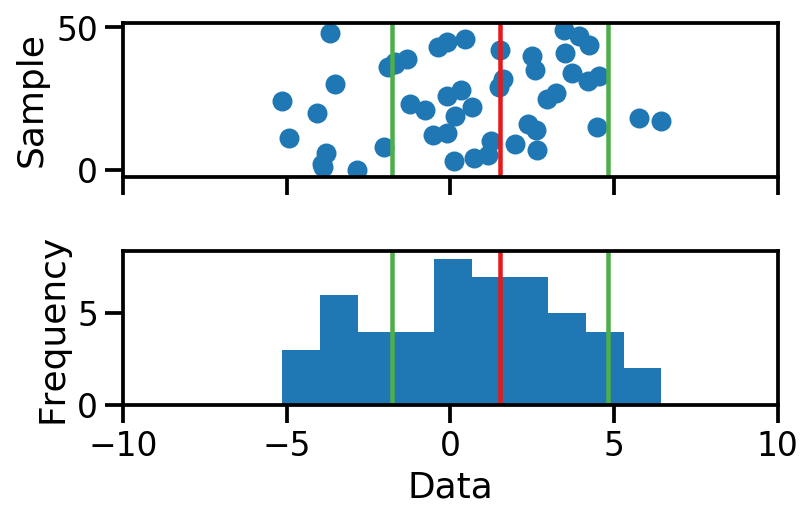

In [30]:
# parameters
μ = 1.5
σ = 3.3
# reps
n = 50

np.random.seed(74382)
real_data = np.random.normal(μ, σ, size=n)

fig, axes = plt.subplots(2, 1, sharex=True)
ax = axes[0]
ax.plot(real_data, range(n), 'o')
ax.axvline(μ, color=red)
ax.axvline(μ-σ, color=green)
ax.axvline(μ+σ, color=green)
ax.set(ylabel='Sample')

ax = axes[1]
ax.hist(real_data)
ax.axvline(μ, color=red)
ax.axvline(μ-σ, color=green)
ax.axvline(μ+σ, color=green)
ax.set(ylabel='Frequency', xlabel='Data', xlim=(-10, 10))

fig.tight_layout()

To summarize the data we will use a histogram:

In [31]:
counts, bins = np.histogram(real_data)
counts

array([3, 6, 4, 4, 8, 7, 7, 5, 4, 2])

Now we sample model parameters from the priors:
$$
\mu \sim U(-10, 10) \\
\sigma \sim U(0, 10)
$$
and simulate data sets using these drawn parameters.

In [11]:
reps = 100000
μs = np.random.uniform(-10, 10, size=reps)
σs = np.random.uniform(0, 10, size=reps)
simulated_data = np.random.normal(μs, σs, size=(n, reps))

We summarize the simulated data:

In [12]:
simulated_data.shape
counts_sim = np.array([
    np.histogram(simulated_data[:,i], bins=bins)[0]
    for i in range(reps)
])

The distance function will be Kullback-Leibler (KL) divergence, which measures the distance between two distributions $p$ and $q$:
$$
d(p, q) = \sum_k{p_k \log{\frac{p_k}{q_k}}}
$$

It is implemented in SciPy using the `entropy` function.
Becuase we cannot have $q_k=0$, which will cause issues in the log, we set all zeros in `counts_sim` to at least $10^-6$.

In [13]:
print((counts_sim==0).any())
counts_sim = counts_sim.astype(float)
counts_sim[counts_sim==0] = 1e-6
print((counts_sim==0).any())

True
False


In [14]:
KL = np.array([entropy(pk=counts, qk=counts_sim[i]) for i in range(reps)])

Instead of an arbitrary choice of $\epsilon$, we reject everything outside of the 5% best percentile.

In [15]:
KL_percentile = np.percentile(KL, 5)
min_idx = KL < KL_percentile

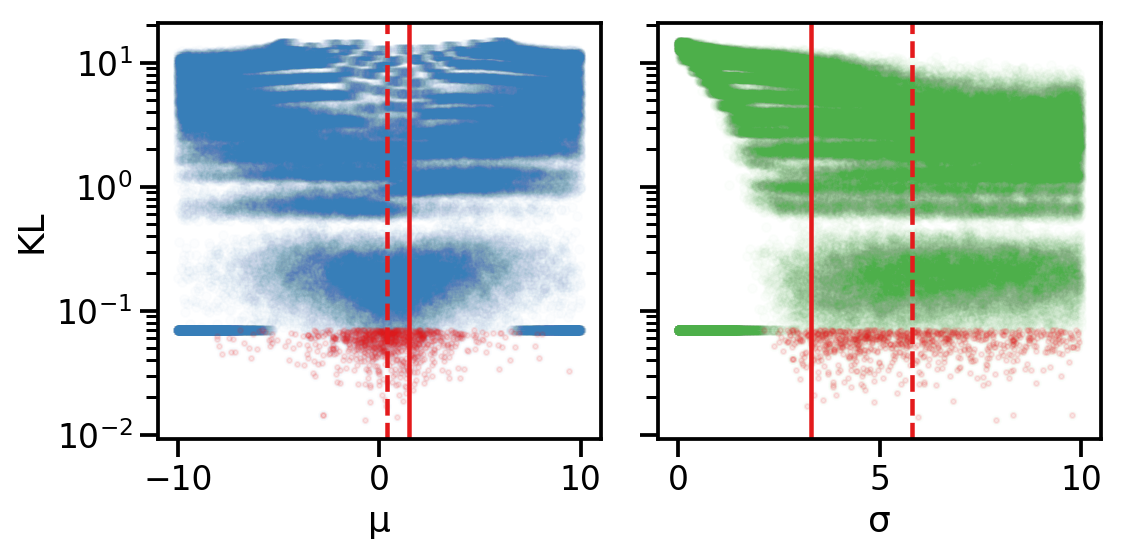

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
plot_kws = dict(marker='.', ls='', alpha=0.01)
argmin_kws = dict(marker='.', ls='', alpha=0.1, color=red, markersize=5)
vline_kws = dict(color=red)
                  
ax = axes[0]
ax.plot(μs, KL, color=blue, **plot_kws)
ax.plot(μs[min_idx], KL[min_idx], **argmin_kws)
ax.axvline(μ, **vline_kws)
ax.axvline(μs[min_idx].mean(), ls='--', **vline_kws)
ax.set(xlabel='μ', yscale='log', ylabel='KL')

ax = axes[1]
ax.plot(σs, KL, color=green, **plot_kws)
ax.plot(σs[min_idx], KL[min_idx], **argmin_kws)
ax.axvline(σ, **vline_kws)
ax.axvline(σs[min_idx].mean(), ls='--', **vline_kws)
ax.set(xlabel='σ')

fig.tight_layout()

The two plots show the KL of all simulations (blue and green) and 5% best simulations (red); the lines show the real parameter value (solid line) and the point estimate based on the best KL (dahsed line).

# Rejection sampling

We now go back to the original rejection sampling.

Given empirical data $x_0$, a model parameterized by the vector $\theta$, and a simulation $f(\theta)$ that implements the model and generates simulated data $x$, the following describes the rejection sampling algorithm:

1. Generate candidate parameter value from the prior $\theta^* \sim \pi(\theta)$  
1. Generate data from the simulation $x^* \sim f(x \mid \theta^*)$.
1. Calculate distance metric $\rho^* = \rho(S(x^*), S(x_0))$
1. Accept $\theta^*$ if $\rho^* \le \epsilon$.

The collection of accepted $\theta^*$ values approximates the posterior distribution $P(\theta \mid x)$.

The problem is that the acceptance rate can be very low.
We'll deal with that in the next section.

In [17]:
ϵ = 0.05

idx_accepted = KL < ϵ
print("Accepted {} ({:.2%}) of {} generated samples".format(
    idx_accepted.sum(), idx_accepted.mean(), idx_accepted.size))
μs_accepted = μs[idx_accepted]
σs_accepted = σs[idx_accepted]

Accepted 231 (0.23%) of 100000 generated samples


We now treat the accepted parameter samples as an approximate to the posterior distribtion:

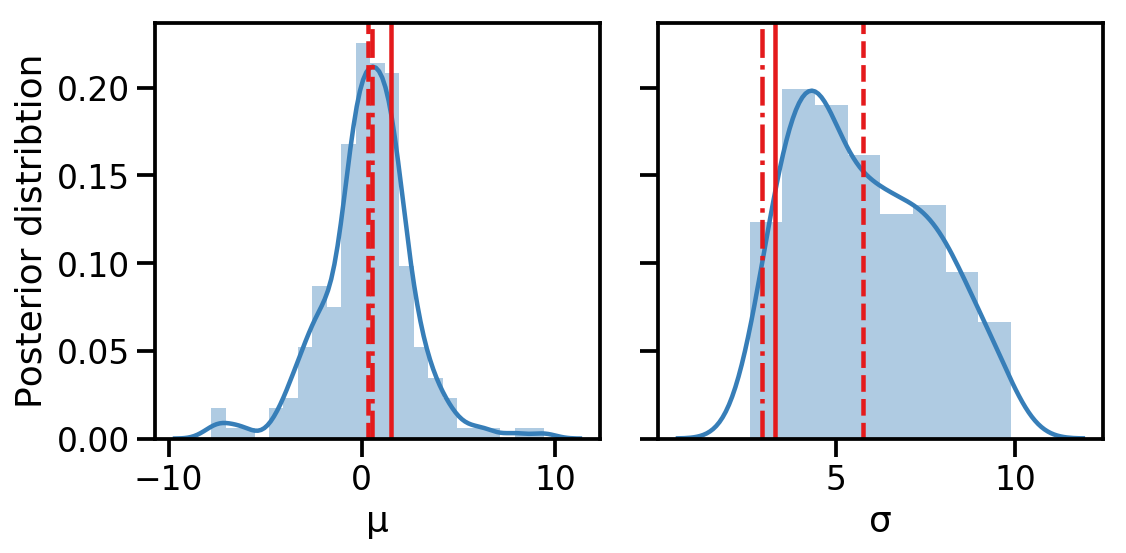

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
distplot_kws = dict()
vline_kws = dict(color=red)

ax = axes[0]
sns.distplot(μs_accepted, color=blue, ax=ax, **distplot_kws)
ax.axvline(μ, **vline_kws)
ax.axvline(real_data.mean(), ls='-.', **vline_kws)
ax.axvline(μs_accepted.mean(), ls='--', **vline_kws)
ax.set(xlabel='μ', ylabel='Posterior distribtion')

ax = axes[1]
sns.distplot(σs_accepted, color=blue, ax=ax, **distplot_kws)
ax.axvline(σ, **vline_kws)
ax.axvline(real_data.std(ddof=1), ls='-.', **vline_kws)
ax.axvline(σs_accepted.mean(), ls='--', **vline_kws)
ax.set(xlabel='σ')

fig.tight_layout()

Again, the solid and dashed lines are the real and point-estimates of the parameters. Its pretty good, especially for the $\mu$.
The dot-dashed line shows the maximum likelihood estimates (the average and the standard deviation with $n-1$ degrees of freedom).

# MCMC sampler

A common sampler that deals with the inefficiency of the rejection sampler is the Markov chain Monte Carlo (MCMC) sampler, which creates chains of accepted parameter samples of length $N$ using the algorithm:

1. Initiaize $\theta_1$, $i=1$.
1. Generate a candidate parameter value $\theta^* \sim q(\theta \mid \theta_i) = N(\theta_i, \eta)$, where $q$ is some poposal density that "explores" the $\theta$-space, usually chosen to be a normal distribution with $\eta$ as the "exploration rate"
1. Generate data from the simulation $x^* \sim f(x \mid \theta^*)$.
1. Calculate distance metric $\rho^* = \rho(S(x^*), S(x_0))$, where $S$ is the summary statistic.
1. If $\rho^* \le \epsilon$, set the acceptance probability $\alpha=1$, otherwise set $\alpha=0$. 
1. Set $\theta_{i+1} = \theta^*$ with probability $min(1,\alpha)$, otherwise set $\theta_{i+1} = \theta_i$; 
1. If $i<N$, increment $i = i + 1$ and go to step 2.

Note: in the more general case, we set $\alpha = \frac{\pi(\theta^*) q(\theta_i \mid \theta^*)}{\pi(\theta_i) q(\theta^* \mid \theta_i)}$, but since the normal distribution is symmetric around the mean, $q(\theta_i \mid \theta^*) = q(\theta^* \mid \theta_i)$, and if we use a uniform prior $\pi(\theta)$, such that $\pi(\theta^*)=\pi(\theta_i)$, then $\alpha = 1$.

This sampling algorithm is much more efficient than the rejection sampling, as it is able to "spend more time" in areas of high likelihood.

However, this algorithm can get stuck on areas of low likelihood.

In [32]:
proposal_width = 0.5 # exploration rate
N = 1000000 # chain length
x_real = real_data.mean() # empirical result
ϵ = 0.05 # acceptance rate
burnin = N // 5 # the first 20% of samples are removed, used only to get closer to the real value

μs, σs = np.empty(N), np.empty(N)
μs[0] = 0 # initial values
σs[0] = 1
for i in range(1, N):
    # generate candidates
    μ_candidate = μs[i-1] + normal(0, proposal_width)
    σ_candidate = max(σs[i-1] + normal(0, proposal_width), 0)
    # generate data form simulation
    x = normal(μ_candidate, σ_candidate)
    # calculate distance
    ρ = abs(x - x_real)
    # accept / reject
    if ρ < ϵ:
        μs[i], σs[i] = μ_candidate, σ_candidate
    else:
        μs[i], σs[i] = μs[i-1], σs[i-1]
        
μs = μs[burnin:]
σs = σs[burnin:]

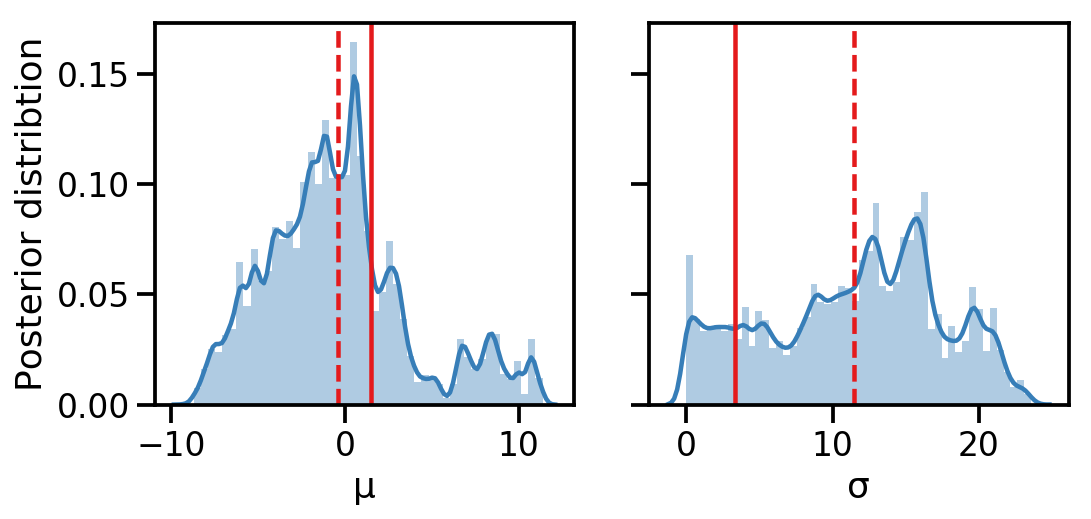

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
distplot_kws = dict()
vline_kws = dict(color=red)

ax = axes[0]
sns.distplot(μs, color=blue, ax=ax, **distplot_kws)
ax.axvline(μ, **vline_kws)
ax.axvline(μs.mean(), ls='--', **vline_kws)
ax.set(xlabel='μ', ylabel='Posterior distribtion')

ax = axes[1]
sns.distplot(σs, color=blue, ax=ax, **distplot_kws)
ax.axvline(σ, **vline_kws)
ax.axvline(σs.mean(), ls='--', **vline_kws)
ax.set(xlabel='σ')

fig.tight_layout()

In [ ]:
ax = sns.kdeplot(μs, σs, shade=True, cmap='viridis')
ax.plot(μ, σ, 'o', color=red)

# Sequential Monte Carlo sampler with pyABC

[pyABC](http://pyabc.readthedocs.io/) is a Python package that implements ABC with a sequential Monte Carlo sampler (SMC) instead of the sampling methods we used above.
This sampler has several advantages -- an adaptive acceptance rate ($\epsilon$), independent sampling of parameters, computational efficiency, and more. For details on the SMC sampler, see [the paper](http://doi.org/10.1073/pnas.0607208104):

> Sisson SA, Fan Y, Tanaka MM (2007) Sequential Monte Carlo without likelihoods. Proc Natl Acad Sci 104(6):1760–1765.

We start with imports - you may need to install first with
```sh
python -m pip install pyABC
```

In [36]:
from pyabc import ABCSMC, RV, Distribution, PercentileDistanceFunction
from pyabc.visualization import plot_kde_1d, plot_kde_2d

Next we define the function $f(\theta)$ that, given model parameter values, runs a single simulation and returns a dictionary of simulation results.
Remember that in our case the model parameters are $\theta=(\mu, \sigma)$.

In [38]:
def model(parameters):
    y = np.random.normal(parameters.μ, parameters.σ)    
    return {"y": y} # return the sample as dictionary

Next we define the prior distribution over $\theta=(\mu, \sigma)$.
It is made of one `RV` (random variable) for each parameter.
The arguments for `uniform` are the lower bound of the uniform distribution and the width of the distribution (so if you set `-10, 10` you effectively have $\mu$ as a constant zero).

In [39]:
prior = Distribution(
    μ=RV("uniform", -10, 20), 
    σ=RV("uniform", 0, 10)
)

Create the `ABCSMC` object, given the model, the prior, and the distance function $\rho$, which we set to `PercentileDistanceFunction` which is the absolute difference $|x - x_0|$ normalized to the statistics of the samples.

In [40]:
abc = ABCSMC(
    model, 
    prior,
    PercentileDistanceFunction(measures_to_use=["y"]) 
)

We create a new ABC run, with a data storage in memory; for heavy runs we might want to have the storage in file or database so that we can load it again later and continue the analysis.

In [41]:
abc_id = abc.new("sqlite://", {"y": real_data.mean()})

INFO:History:Start <ABCSMC(id=1, start_time=2018-12-24 22:39:49.175327, end_time=None)>
INFO:Epsilon:initial epsilon is 0.4312364216099238


We now run the ABC algorithm until either the adapted acceptance rate drops below 5% or the number of parameter popualtions is 2 (the populations are like consecutive runs of the search algorithm, see details in paper cited above).

In [42]:
history = abc.run(minimum_epsilon=0.05, max_nr_populations=2)

INFO:ABC:t:0 eps:0.4312364216099238
INFO:ABC:t:1 eps:0.19874268919046165
INFO:History:Done <ABCSMC(id=1, start_time=2018-12-24 22:39:49.175327, end_time=2018-12-24 22:40:09.493859)>


`history` has all the collected distributions; the `0` indexes the models used, but we only used the one model.

In [43]:
params, weights = history.get_distribution(0)
params.head()

name,μ,σ
id,,
102,-0.123507,3.819882
103,0.026912,3.802826
104,2.507236,0.089134
105,0.507674,1.484764
106,-2.908947,2.122198


Finally we can plot the obtained posterior, which is encoded in the `params` data frame and the `weights` array.

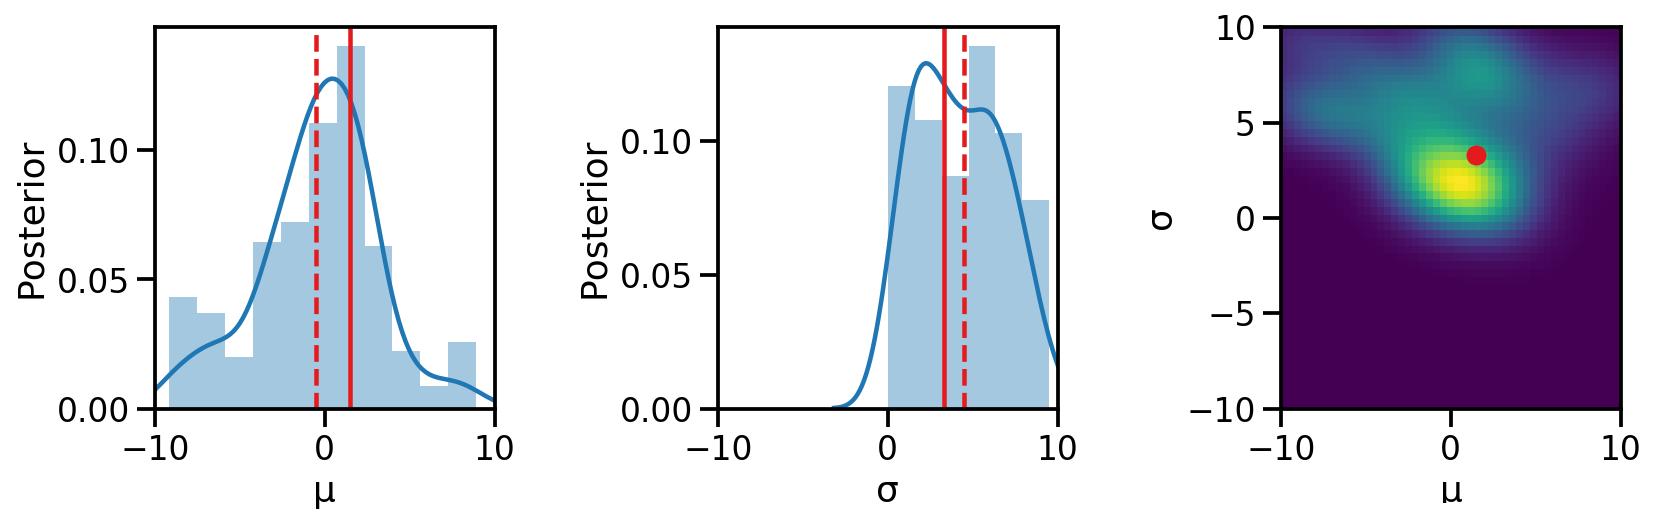

In [45]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for param_name, param_real_value, ax in zip(['μ', 'σ'], [μ, σ], axes.flat):
    sns.distplot(params[param_name], hist_kws=dict(weights=weights), ax=ax)
    ax.axvline(param_real_value, color=red)
    ax.axvline(params[param_name].values @ weights, color=red, ls='--')
    ax.set(xlim=(-10, 10), xlabel=param_name, ylabel='Posterior')
    
ax = axes[2]
plot_kde_2d(params, weights, 'μ', 'σ', xmin=-10, xmax=10, ymin=-10, ymax=10, 
            ax=ax, colorbar=False, title=False)
ax.plot(μ, σ, 'o', color=red)

fig.tight_layout()

On the two left figures we see again the posterior on the model parameters, with solid and dashed lines for the real and estimated parameter values.
On the right we see an estimated joint distribution (using a kernel density estimate), with the real parameter value in a red dot.

# Using ABC with real data

We follow the analysis from a [paper on animal social networks](https://www.nature.com/articles/ncomms12084)
> Ilany A, Akçay E (2016) Social inheritance can explain the structure of animal social networks. Nat Commun 7(May). doi:10.1038/ncomms12084.

To work with graphs and networks we use [NetworkX](https://networkx.github.io), and we require at least version 2.

In [46]:
import networkx as nx
print('NetworkX', nx.__version__)

def show_net(network):
    G = nx.from_numpy_array(network)
    nx.draw_spring(G, node_color='#4466ee', alpha=0.8)

NetworkX 2.2


## The Dolphins data

We download the dolphins data from [KONECT](http://konect.uni-koblenz.de/networks/dolphins); this site has a bunch of network data.

Now load the data and convert it to NumPy adjacency matrix.

In [47]:
dolphin_data = np.loadtxt('../data/dolphins/out.dolphins', comments='%', dtype=int)
dolphin_data[:5]

array([[ 9,  4],
       [10,  6],
       [10,  7],
       [11,  1],
       [11,  3]])

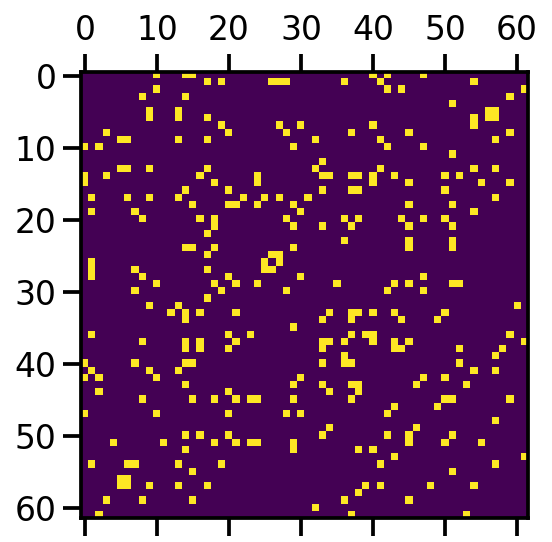

In [48]:
N = dolphin_data.max() # dolphin ids go from 1 to 62
dolphin_network = np.zeros((N, N), dtype=int)
for row in dolphin_data:
    src, dst = row
    # to zero count
    src -= 1
    dst -= 1
    # set connection
    dolphin_network[dst, src] = 1
    dolphin_network[src, dst] = 1
plt.matshow(dolphin_network);

/Users/yoavram/miniconda3/envs/SciComPy/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


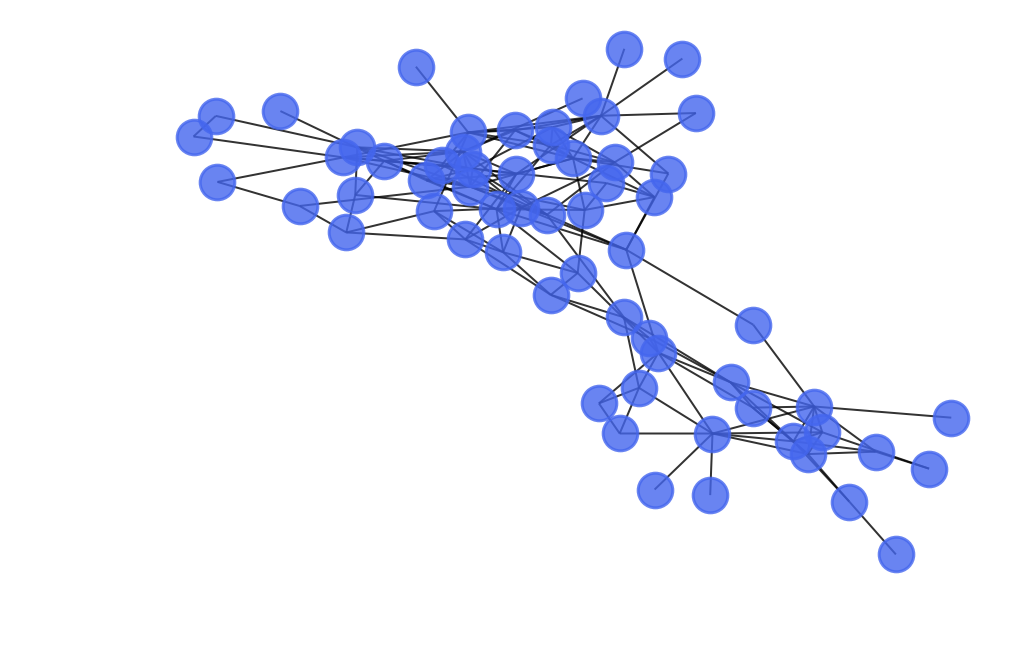

In [50]:
show_net(dolphin_network)

We calculate the summary statistics, which are the mean degree of network nodes, and the clustering coefficient. 
- Degree of a node is the number of edges connected to it.
- Clustering coefficient of a node is the fraction of possible triangles through that node that exist, that is $\frac{2 T(u)}{deg(u)(deg(u)-1)}$, where $T(u)$ is the number of triangles passing through the node and $deg(u)$ is the node degree.

In [51]:
def mean_degree(network):
    return network.sum(axis=0).mean()

def clustering_coefficient(network):
    G = nx.from_numpy_matrix(network)
    clustering = nx.algorithms.clustering(G)
    return np.mean(list(clustering.values()))

In [52]:
d_mean_degree = mean_degree(dolphin_network)
d_clustering_coefficient = clustering_coefficient(dolphin_network)

## Simulate the network process

We follow the description in section _Simulation process_ of the paper by [Ilany and Akçay](https://www.nature.com/articles/ncomms12084).

For the initial networks, use the [Erdos-Renyi random network generator](https://networkx.github.io/documentation/networkx-1.9/reference/generated/networkx.generators.random_graphs.erdos_renyi_graph.html); [read more on these random graphs](https://en.wikipedia.org/wiki/Erdős–Rényi_model).

In [53]:
def simulation(pn, pr):
    tmax = 20 * N
    deaths = np.random.randint(0, N, size=tmax)
    births = np.random.randint(0, N, size=tmax)
    G = nx.erdos_renyi_graph(N, p=0.1/2)
    network = nx.to_numpy_array(G, dtype=int)
    
    for t in range(tmax):
        d = deaths[t]
        b = births[t]
        network[d,:] = False
        network[:,d] = False
        moms_friends = network[b,:]
        rand = np.random.random(N)
        from_mom = moms_friends & (rand < pn)
        from_random = ~moms_friends & (rand < pr)
        network[d, :] = from_mom | from_random 
        network[d,b] = True
        network[:, d] = network[d, :]

    return network

We set $p_n$ and $p_r$ to the values found by [Ilany and Akçay](https://www.nature.com/articles/ncomms12084) (see Table 1) and simulate a network.

/Users/yoavram/miniconda3/envs/SciComPy/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


Simulated mean degree 4.870967741935484 and clustering coefficients 0.31857049760275574


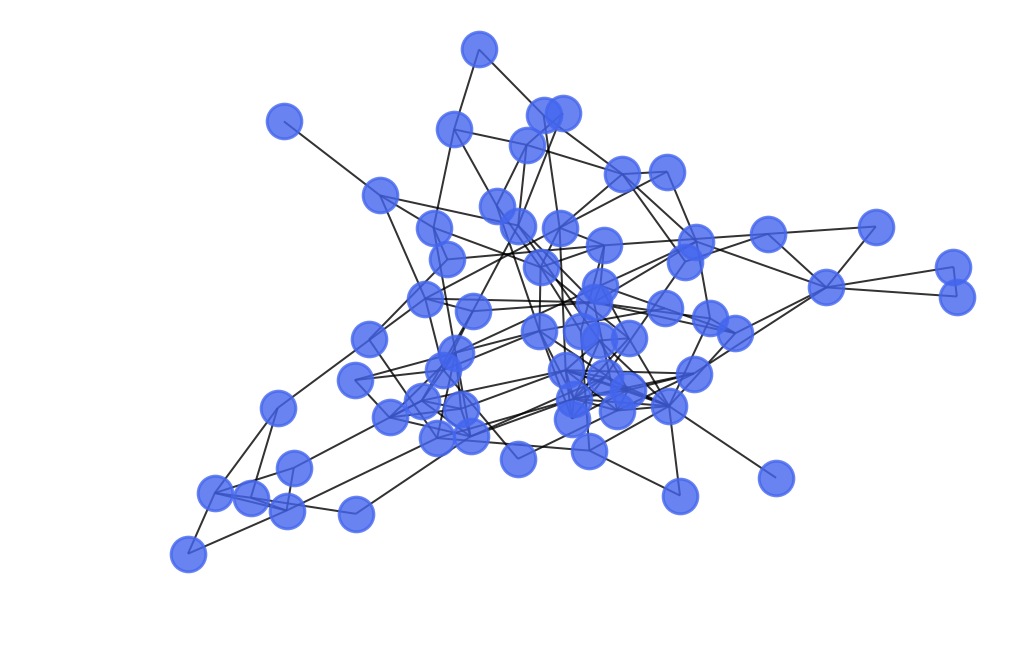

In [55]:
pn=0.5
pr=0.028
network = simulation(pn=pn, pr=pr)
show_net(network)
print("Simulated mean degree {} and clustering coefficients {}".format(mean_degree(network), clustering_coefficient(network)))      

## Parameter inference with ABC

Now we'll use ABC to estimate the model parameters $p_n$ and $p_r$, and see if it finds estimates that are close to those from the paper.

We follow the same steps as above.

Our model function runs a simulation with the parameters then returns the mean degree and clustering coefficient, which are our summary statistics.

We set an uninformative prior $U(0,1)$ on both $p_n$ and $p_r$.

Otherwise everything is the same as before.

In [56]:
def model(parameters):
    network = simulation(pn=parameters.pn, pr=parameters.pr)
    return dict(
        mean_degree=mean_degree(network),
        clustering_coefficient=clustering_coefficient(network)
    )

prior = Distribution(
    pn=RV("uniform", 0, 1), 
    pr=RV("uniform", 0, 1)
)

abc = ABCSMC(
    model, 
    prior,
    PercentileDistanceFunction(measures_to_use=["mean_degree", "clustering_coefficient"]) 
)

abc_id = abc.new("sqlite://", dict(mean_degree=d_mean_degree, clustering_coefficient=d_clustering_coefficient))

INFO:History:Start <ABCSMC(id=1, start_time=2018-12-24 22:50:16.083835, end_time=None)>
INFO:Epsilon:initial epsilon is 1.311654897061389


Let's run the sampling.

This will take a while, increase epsilon or decrease populations to finish earlier.
Also, note that pyABC automatically leverages all your CPUs, so this will run faster on a machine with multiple cores (like my lab server or a cloud HPC server).

In [19]:
history = abc.run(minimum_epsilon=0.01, max_nr_populations=10)

INFO:ABC:t:5 eps:0.19847258635377754
INFO:ABC:t:6 eps:0.14452075808397977
INFO:ABC:t:7 eps:0.10920992154792965
INFO:ABC:t:8 eps:0.07675572269603367
INFO:ABC:t:9 eps:0.05029156293255868
INFO:ABC:t:10 eps:0.03611363691026857
INFO:ABC:t:11 eps:0.02453058838157635
INFO:ABC:t:12 eps:0.019549867400540526
INFO:ABC:t:13 eps:0.014809506899629381
INFO:ABC:t:14 eps:0.010034963252549088
INFO:History:Done <ABCSMC(id=1, start_time=2018-07-04 18:24:32.486439, end_time=2018-07-04 18:31:18.388732)>


In [20]:
params, weights = history.get_distribution(0)
params.head()

name,pn,pr
id,,
1402,0.460888,0.029609
1403,0.460802,0.031296
1404,0.398239,0.039214
1405,0.368614,0.037813
1406,0.412550,0.041756


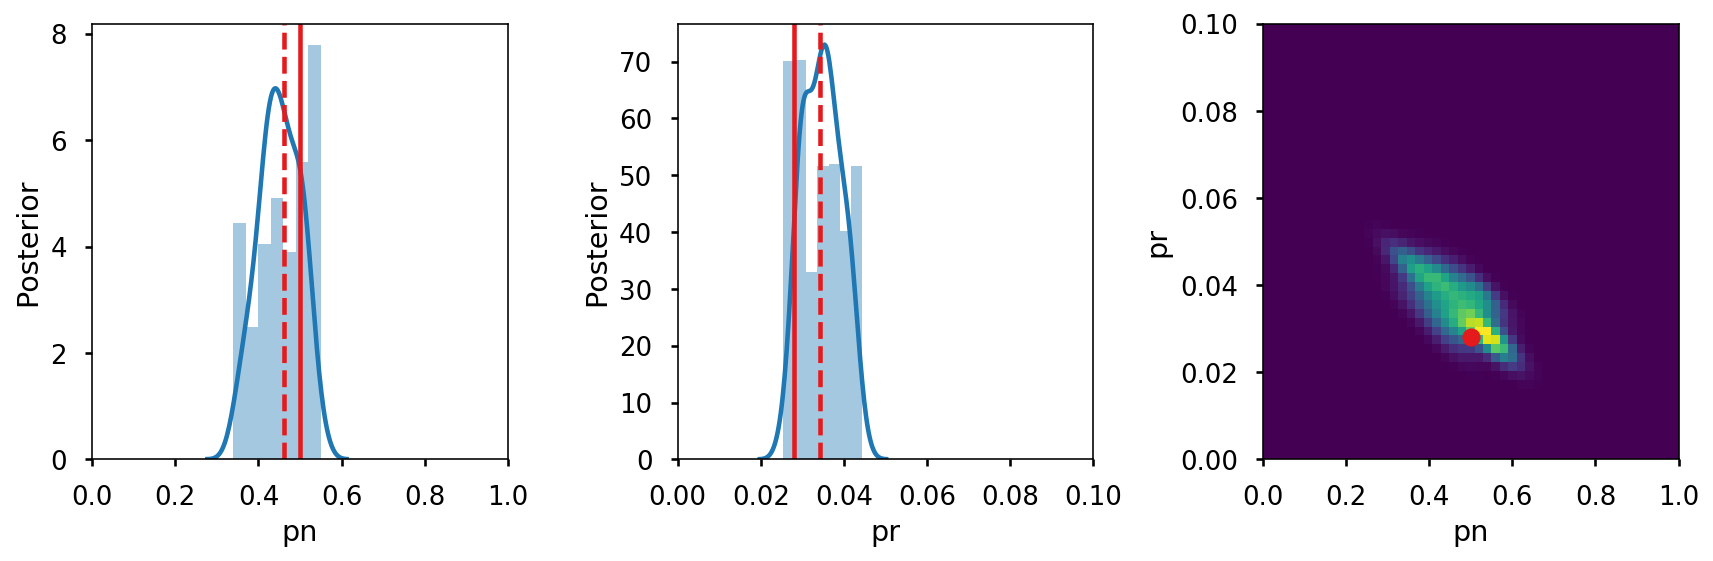

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for param_name, param_real_value, ax in zip(['pn', 'pr'], [pn, pr], axes.flat):
    sns.distplot(params[param_name], hist_kws=dict(weights=weights), ax=ax)
    ax.axvline(param_real_value, color=red)
    ax.axvline(params[param_name].values @ weights, color=red, ls='--')
    ax.set(xlim=(0, 1), xlabel=param_name, ylabel='Posterior')
axes[1].set(xlim=(0, 0.1))

ax = axes[2]
plot_kde_2d(params, weights, 'pn', 'pr', xmin=0, xmax=1, ymin=0, ymax=0.1, 
            ax=ax, colorbar=False, title=False)
ax.plot(pn, pr, 'o', color=red)

fig.tight_layout()

Here the red mark are the estimates from the original paper, so we find very similar results to those found in the original paper.

# References

- [Scott Linderman's notes on ABC](https://casmls.github.io/general/2016/10/02/abc.html)
- [Tanaka et al](http://doi.org/10.1534/genetics.106.055574)' paper on ABC-MCMC analysis of Tubercolosis in San Francisco
- [Sisson et al](http://doi.org/10.1073/pnas.0607208104)'s paper on ABC-SMC